# Lab Assignment Five: Wide & Deep Network Architectures

## Team Members
1. Piyush Metkar  - 47509180
2. Rishab Vaishya - 47505527
3. Dhaval Gogri   - 47444609

# BUSINESS UNDERSTANDING

REFERENCE : https://www.kaggle.com/moltean/fruits/data

This dataset is taken from Kaggle and it is about different type of fruits whose images are taken at different angles in 360 degrees. The photos have been taken by first keeping the fruit in vertical standing position and then by laying it in horizontal position. 360 degrees gives you an angle from each and every side making accuracy pretty high.

The study of this project will help companies such as Tropicana which sell fruit packets, fruit juices, or anything related to fruit. The company might have a manufacturing facility where many different kinds of fruit products are made. This model can be implemented for automating processes such as sorting of fruits according to their kind. 

When the container of these fruits arrive at the manufacturing facility, the software will recognize the fruit by using our machine learning algorithm and send the container to its respective place. It is very important to have a very high accuracy in this regard as one fruit cannot be mixed with another fruit. Because if some fruit is mixed with another fruit like banana with litchie, it will spoil the entire batch.

Further development in this study will also help in detecting fruit quality depending on the size, shape, color and texture etc which in turn would help throw away rotten fruit and only keep the fresh and the quality ones.

This technique when implemented can also be useful for other food product other than fruits like food grains, meat etc subject to availability of those respective images to train the dataset.

Even while farming, the quality of the fruit can be continuously monitored and data can be collected about its growth. If any issue is found, corrective measures can be taken immediately to prevent any losses to farmers. 

For this case we are looking the model to perform at really good rate and expect accuracy more than 90%.


# 1. GRADING RUBRIC

## 1.1 Evaluation Metric

The business case that we are considering for this project is a situation where we will be segregating the fruits as per their types. After the frutis are segregated, they will go to their respective jobs which could be either getting juice, pulp, jams or even shampoo depending on fruit type.

So it is important to identitfy the correct fruit and classify it in proper type. Let's say we are segregating a batch of apples and there comes one litchie among the apples which is falsely classified as an apple. If this litchie goes unnoticed with all the apples to get juice, it will not only spoil the entire batch of apple. But also will cause serious health issues to customers having allergy due to litchie who will buy the product thinking apple juice.

Hence the evaluation metric that we will be choosing is **Accuracy and precision** because we want higher number of true positives and lower number of false positives.

## 1.2 Cross Validation

For cross validation we will be using **K-Fold Cross Validation** technique with 10 folds. This is because we have very even distribution of data for all the classes. The model will be trained for 9 folds in each iteration and will be validated on 10th fold.

Also in the dataset, we have separate test data included. Hence the trained model will be tested on the test data.


# 2. Modeling
We are using the following reference to import the data images from dataset and thus preparing the data for model.

https://www.kaggle.com/naveenc131/cnn-with-accuracy-of-98

## 2.1 Data Expansion

Let's consider an example where there are multiple fruits which are travelling on a conveyor belt. These fruits may be present in any orientation. In dataset, we have images taken in such a way that each fruit is kept vertically standing and horizontally laid down position and then the images are taken from all the angles. This doesn't  actually cover the upside down orientation of the fruit.

Hence we are **vertically flipping** the images so that our model also covers the upside down orientation of fruit. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os

import itertools

from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization
from keras.optimizers import Adamax
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.neural_network import MLPClassifier

Using TensorFlow backend.


In [15]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [17]:
IMAGE_SIZE = 100

training_fruit_img = []
training_label = []

training_fruit_img_bw = []
training_label_bw = []

for dir_path in glob.glob("/Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 6/fruits-360/Training/*"):
    img_label = dir_path.split("/")[-1]
# for dir_path in glob.glob(r'D:\Downloads\Notes\CSE_7324_ML\fruits-360_dataset_2018_02_08\Training\*'):
#     img_label = dir_path.split("\\")[-1]
    
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        #Read the images
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        
        image_bw = rgb2gray(image)    #Grayscale images for MLP
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        #OpenCV swaps the Red and Blue channels while reading images.
        image_vf =  cv2.flip( image, 1 )                      #Vertically flipping images for data expansion
        
        
        image_bw = image_bw.flatten()
        
        training_fruit_img.append(image)
        training_fruit_img.append(image_vf)
        training_fruit_img_bw.append(image_bw)
        
        training_label.append(img_label)
        training_label.append(img_label)
        training_label_bw.append(img_label)

training_fruit_img = np.array(training_fruit_img)
training_fruit_img_bw = np.array(training_fruit_img_bw)
training_label = np.array(training_label)
training_label_bw = np.array(training_label_bw)

print(training_fruit_img.shape)
print(training_fruit_img_bw.shape)

(57472, 100, 100, 3)
(28736, 10000)


In [3]:
label_to_id = {v:k for k,v in enumerate(np.unique(training_label)) }
id_to_label = {v:k for k,v in label_to_id.items() }

id_to_label

{0: 'Apple Braeburn',
 1: 'Apple Golden 1',
 2: 'Apple Golden 2',
 3: 'Apple Golden 3',
 4: 'Apple Granny Smith',
 5: 'Apple Red 1',
 6: 'Apple Red 2',
 7: 'Apple Red 3',
 8: 'Apple Red Delicious',
 9: 'Apple Red Yellow',
 10: 'Apricot',
 11: 'Avocado',
 12: 'Avocado ripe',
 13: 'Banana',
 14: 'Banana Red',
 15: 'Cactus fruit',
 16: 'Carambula',
 17: 'Cherry',
 18: 'Clementine',
 19: 'Cocos',
 20: 'Dates',
 21: 'Granadilla',
 22: 'Grape Pink',
 23: 'Grape White',
 24: 'Grape White 2',
 25: 'Grapefruit Pink',
 26: 'Grapefruit White',
 27: 'Guava',
 28: 'Huckleberry',
 29: 'Kaki',
 30: 'Kiwi',
 31: 'Kumquats',
 32: 'Lemon',
 33: 'Lemon Meyer',
 34: 'Limes',
 35: 'Litchi',
 36: 'Mandarine',
 37: 'Mango',
 38: 'Maracuja',
 39: 'Nectarine',
 40: 'Orange',
 41: 'Papaya',
 42: 'Passion Fruit',
 43: 'Peach',
 44: 'Peach Flat',
 45: 'Pear',
 46: 'Pear Abate',
 47: 'Pear Monster',
 48: 'Pear Williams',
 49: 'Pepino',
 50: 'Pineapple',
 51: 'Pitahaya Red',
 52: 'Plum',
 53: 'Pomegranate',
 54: 'Q

In [6]:
training_label_id = np.array([label_to_id[i] for i in training_label])
training_label_bw_id = np.array([label_to_id[i] for i in training_label_bw])

training_label_id.shape, training_label_bw_id.shape

((57472,), (28736,))

In [7]:
validation_fruit_img=[]
validation_label =[]

for dir_path in glob.glob("/Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 6/fruits-360/Validation/*"):
    img_label = dir_path.split("/")[-1]
# for dir_path in glob.glob(r'D:\Downloads\Notes\CSE_7324_ML\fruits-360_dataset_2018_02_08\Validation\*'):
#     img_label = dir_path.split("\\")[-1]

for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        validation_fruit_img.append(image)
        validation_label.append(img_label)
        
validation_fruit_img = np.array(validation_fruit_img)
validation_label = np.array(validation_label)

validation_label_id = np.array([label_to_id[i] for i in validation_label])

validation_fruit_img.shape,validation_label_id.shape

((164, 100, 100, 3), (164,))

In [9]:
X_train,X_test = training_fruit_img,validation_fruit_img
Y_train,Y_test =training_label_id,validation_label_id
#mean(X) = np.mean(X_train)
X_train = X_train/255
X_test = X_test/255

X_flat_train = X_train.reshape(X_train.shape[0],IMAGE_SIZE*IMAGE_SIZE*3)
X_flat_test = X_test.reshape(X_test.shape[0],IMAGE_SIZE*IMAGE_SIZE*3)

#One Hot Encode the Output
Y_train = keras.utils.to_categorical(Y_train, 60)
Y_test = keras.utils.to_categorical(Y_test, 60)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_flat_train.shape, X_flat_test.shape)

Original Sizes: (57472, 100, 100, 3) (164, 100, 100, 3) (57472, 60) (164, 60)
Flattened: (57472, 30000) (164, 30000)


(100, 100, 3)


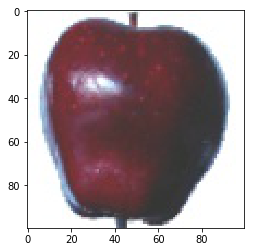

Apple Red Delicious


In [12]:
print(X_train[500].shape)
plt.imshow(X_train[500])

plt.show()
#print(Y_train[490])
print(id_to_label[np.argmax(Y_train[500], axis=None, out=None)])


In [28]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_accs = []
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_acc = accuracy_score(val_targ, val_predict)
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_accs.append(_val_acc)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ('val_precision:', _val_precision)# — val_acc: %f — val_precision: %f — val_recall %f” %(_val_f1, _val_precision, _val_recall)
        return
 
metrics = Metrics()

## 2.2 CNN Models

### Model 1

In [27]:
model_1 = Sequential()
model_1.add(Conv2D(16,(3,3),input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),padding='same'))
model_1.add(Activation("relu"))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Flatten())
model_1.add(Dense(256,activation='elu'))
model_1.add(LeakyReLU(0.1))
model_1.add(Dropout(0.5))
model_1.add(Dense(60))
model_1.add(Activation("softmax"))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
activation_7 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               10240256  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
__________

In [ ]:
model_1.compile(loss='categorical_crossentropy',
             optimizer = Adamax(),
             metrics=['accuracy'])

model_1.fit(X_train,
          Y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data = (X_test,Y_test),
          callbacks=[metrics]
         )

In [ ]:
import os

for image_path in glob.glob("/Users/dhavalgogri/Downloads/fruits-360_dataset_2018_02_08/fruits-360/Training/*"):
    image_label = image_path.split("/")[-1]
    os.makedirs("/Users/dhavalgogri/Downloads/fruits-360_dataset_2018_02_08/fruits-360/new_dataset/",image_label)
    for image_path in glob.glob(os.path.join(image_path,"*.jpg")):
        if 
        shutil.move("path/to/current/file.foo", "path/to/new/destination/for/file.foo")